**In case of problems or questions, please first check the list of [Frequently Asked Questions (FAQ)](https://stardist.net/docs/faq.html).**

Please shutdown all other training/prediction notebooks before running this notebook (as those might occupy the GPU memory otherwise).

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist import Rays_GoldenSpiral
from stardist.matching import matching, matching_dataset
from stardist.models import Config3D, StarDist3D, StarDistData3D

np.random.seed(42)
lbl_cmap = random_label_cmap()

/tmp/ipykernel_2268598/2713708310.py:5: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  matplotlib.rcParams["image.interpolation"] = None
2024-08-15 15:01:42.264658: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


# Data

We assume that data has already been downloaded via notebook [1_data.ipynb](1_data.ipynb).  

<div class="alert alert-block alert-info">
Training data (for input `X` with associated label masks `Y`) can be provided via lists of numpy arrays, where each image can have a different size. Alternatively, a single numpy array can also be used if all images have the same size.  
Input images can either be three-dimensional (single-channel) or four-dimensional (multi-channel) arrays, where the channel axis comes last. Label images need to be integer-valued.
</div>

In [2]:
#/home/home/ProjectCode/stardist/data/StartDistDataset/NucSegTraining
X = sorted(glob('/home/home/ProjectCode/stardist/data/DuzhuoImageTraining/images/*.tif'))
Y = sorted(glob('/home/home/ProjectCode/stardist/data/DuzhuoImageTraining/masks/*.tif'))
# X = X[:185]
# Y = Y[:185]

In [3]:
X = list(map(imread,X))
Y = list(map(imread,Y))
n_channel = 1 if X[0].ndim == 3 else X[0].shape[-1]

In [4]:
print(X[0].shape, Y[0].shape)

(136, 300, 184) (136, 300, 184)


Normalize images and fill small label holes.

In [5]:
axis_norm = (0,1,2)   # normalize channels independently
# axis_norm = (0,1,2,3) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 3 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|█████████████████████████████████████████████████████████████████████████| 550/550 [08:52<00:00,  1.03it/s]


Split into train and validation datasets.

In [6]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.2 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images: 550
- training:       440
- validation:     110


Training data consists of pairs of input image and label instances.

In [7]:
def plot_img_label(img, lbl, img_title="image (XY slice)", lbl_title="label (XY slice)", z=None, **kwargs):
    if z is None:
        z = img.shape[0] // 2    
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img[z], cmap='gray', clim=(0,1))
    ai.set_title(img_title)    
    fig.colorbar(im, ax=ai)
    al.imshow(lbl[z], cmap=lbl_cmap)
    al.set_title(lbl_title)
    plt.tight_layout()

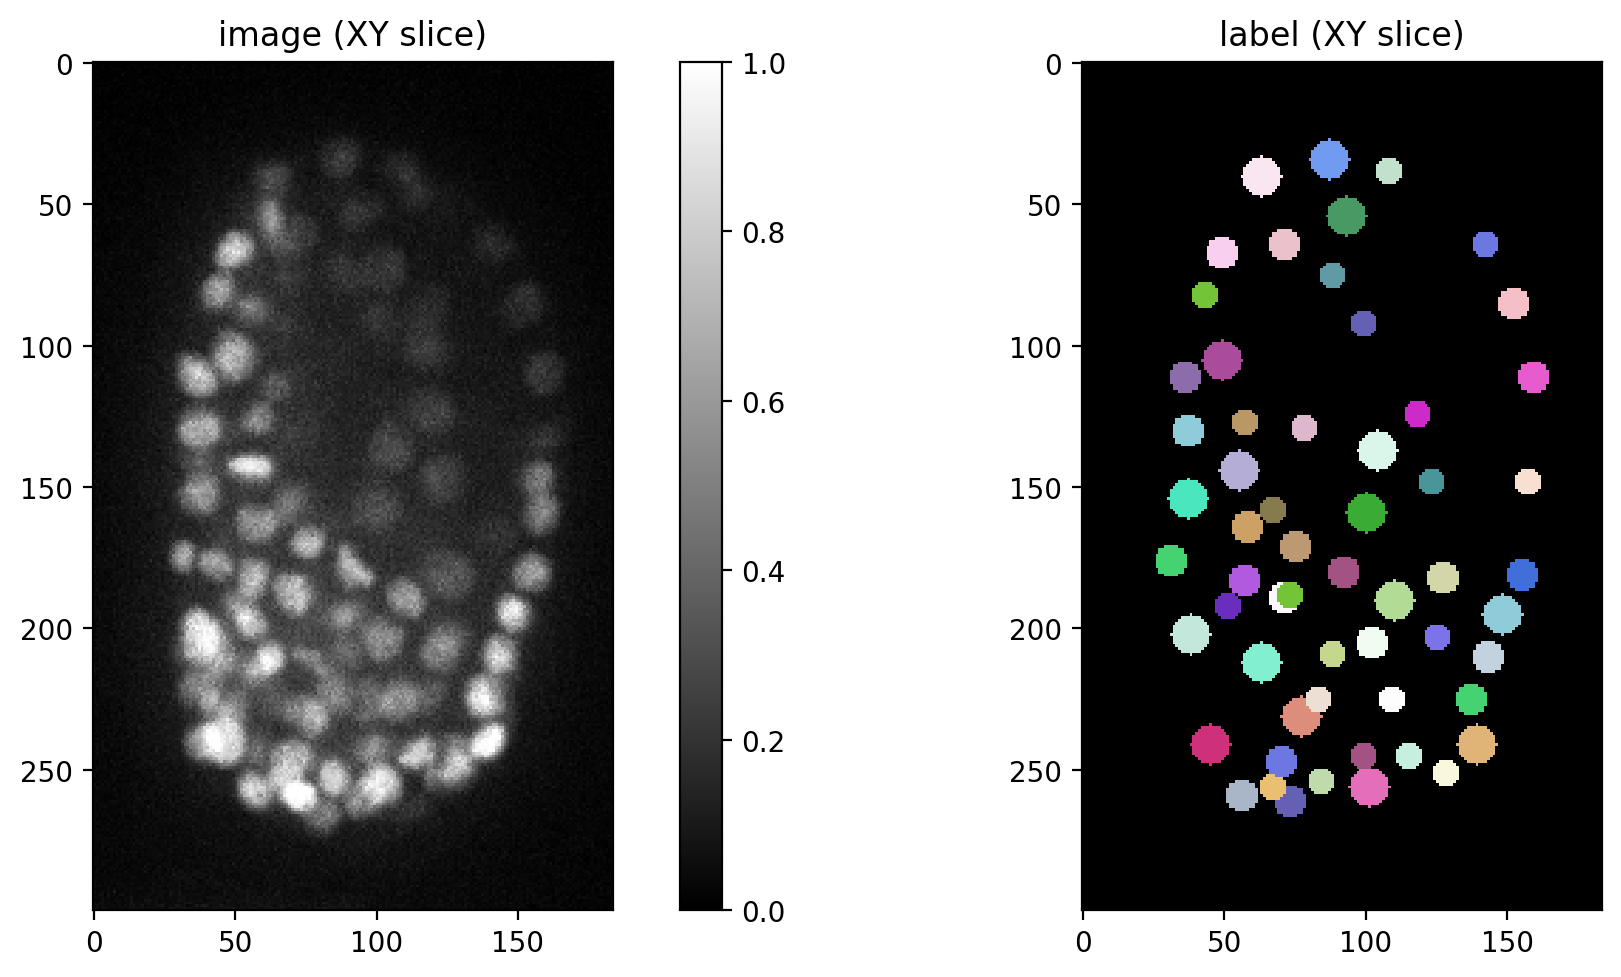

In [8]:
i = 184
img, lbl = X[i], Y[i]
assert img.ndim in (3,4)
img = img if img.ndim==3 else img[...,:3]
plot_img_label(img,lbl)
None;

# Configuration

A `StarDist3D` model is specified via a `Config3D` object.

In [9]:
print(Config3D.__doc__)

Configuration for a :class:`StarDist3D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    rays : Rays_Base, int, or None
        Ray factory (e.g. Ray_GoldenSpiral).
        If an integer then Ray_GoldenSpiral(rays) will be used
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    n_classes : None or int
        Number of object classes to use for multi-class predection (use None to disable)
    anisotropy : (float,float,float)
        Anisotropy of objects along each of the axes.
        Use ``None`` to disable only for (nearly) isotropic objects shapes.
        Also see ``utils.calculate_extents``.
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
  

In [10]:
extents = calculate_extents(Y)
anisotropy = tuple(np.max(extents) / extents)
print('empirical anisotropy of labeled objects = %s' % str(anisotropy))

empirical anisotropy of labeled objects = (1.0, 1.0, 1.0)


In [12]:
# 96 is a good default choice (see 1_data.ipynb)
n_rays = 96

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = False and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = tuple(1 if a > 1.5 else 2 for a in anisotropy)

# Use rays on a Fibonacci lattice adjusted for measured anisotropy of the training data
rays = Rays_GoldenSpiral(n_rays, anisotropy=anisotropy)

conf = Config3D (
    rays             = rays,
    grid             = grid,
    anisotropy       = anisotropy,
    use_gpu          = use_gpu,
    n_channel_in     = n_channel,
    # adjust for your data below (make patch size as large as possible)
    train_patch_size = (128,128,128),
    train_batch_size = 1,
)
print(conf)
vars(conf)

Config3D(anisotropy=(1.0, 1.0, 1.0), axes='ZYXC', backbone='unet', grid=(2, 2, 2), n_channel_in=1, n_channel_out=97, n_classes=None, n_dim=3, n_rays=96, net_conv_after_unet=128, net_input_shape=(None, None, None, 1), net_mask_shape=(None, None, None, 1), rays_json={'name': 'Rays_GoldenSpiral', 'kwargs': {'n': 96, 'anisotropy': (1.0, 1.0, 1.0)}}, train_background_reg=0.0001, train_batch_size=1, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_class_weights=(1, 1), train_dist_loss='mae', train_epochs=400, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=(1, 0.2), train_n_val_patches=None, train_patch_size=(128, 128, 128), train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, train_sample_cache=True, train_steps_per_epoch=100, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel_size=(3, 3, 3), unet_last_activation='relu', unet_n_co

{'n_dim': 3,
 'axes': 'ZYXC',
 'n_channel_in': 1,
 'n_channel_out': 97,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 96,
 'grid': (2, 2, 2),
 'anisotropy': (1.0, 1.0, 1.0),
 'backbone': 'unet',
 'rays_json': {'name': 'Rays_GoldenSpiral',
  'kwargs': {'n': 96, 'anisotropy': (1.0, 1.0, 1.0)}},
 'n_classes': None,
 'unet_n_depth': 2,
 'unet_kernel_size': (3, 3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, None, 1),
 'net_mask_shape': (None, None, None, 1),
 'train_patch_size': (128, 128, 128),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_class_weights':

In [13]:
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    #limit_gpu_memory(0.8)
    # alternatively, try this:
    # limit_gpu_memory(None, allow_growth=True)

**Note:** The trained `StarDist3D` model will *not* predict completed shapes for partially visible objects at the image boundary.

In [14]:
model = StarDist3D(conf, name='stardist_nuc', basedir='models')

base_model.py (149): output path for model already exists, files may be overwritten: /home/home/ProjectCode/stardist/examples/3D/models/stardist_nuc
2024-08-15 15:14:11.743504: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-08-15 15:14:11.755406: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-08-15 15:14:12.569221: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:d5:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2024-08-15 15:14:12.569274: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2024-08-15 15:14:12.585457: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcubl

Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.7968, nms_thresh=0.3.


Check if the neural network has a large enough field of view to see up to the boundary of most objects.

In [15]:
median_size = calculate_extents(Y, np.median)
fov = np.array(model._axes_tile_overlap('ZYX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

2024-08-15 15:15:19.676432: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-08-15 15:15:19.691003: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2100000000 Hz
2024-08-15 15:15:19.891908: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2024-08-15 15:15:23.339356: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2024-08-15 15:15:24.033201: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


median object size:      [19. 19. 19.]
network field of view :  [46 46 46]


# Data Augmentation

You can define a function/callable that applies augmentation to each batch of the data generator.  
We here use an `augmenter` that applies random rotations, flips, and intensity changes, which are typically sensible for (3D) microscopy images (but you can disable augmentation by setting `augmenter = None`).

In [16]:
def random_fliprot(img, mask, axis=None): 
    if axis is None:
        axis = tuple(range(mask.ndim))
    axis = tuple(axis)
            
    assert img.ndim>=mask.ndim
    perm = tuple(np.random.permutation(axis))
    transpose_axis = np.arange(mask.ndim)
    for a, p in zip(axis, perm):
        transpose_axis[a] = p
    transpose_axis = tuple(transpose_axis)
    img = img.transpose(transpose_axis + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(transpose_axis) 
    for ax in axis: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img

def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    # Note that we only use fliprots along axis=(1,2), i.e. the yx axis 
    # as 3D microscopy acquisitions are usually not axially symmetric
    x, y = random_fliprot(x, y, axis=(1,2))
    x = random_intensity_change(x)
    return x, y


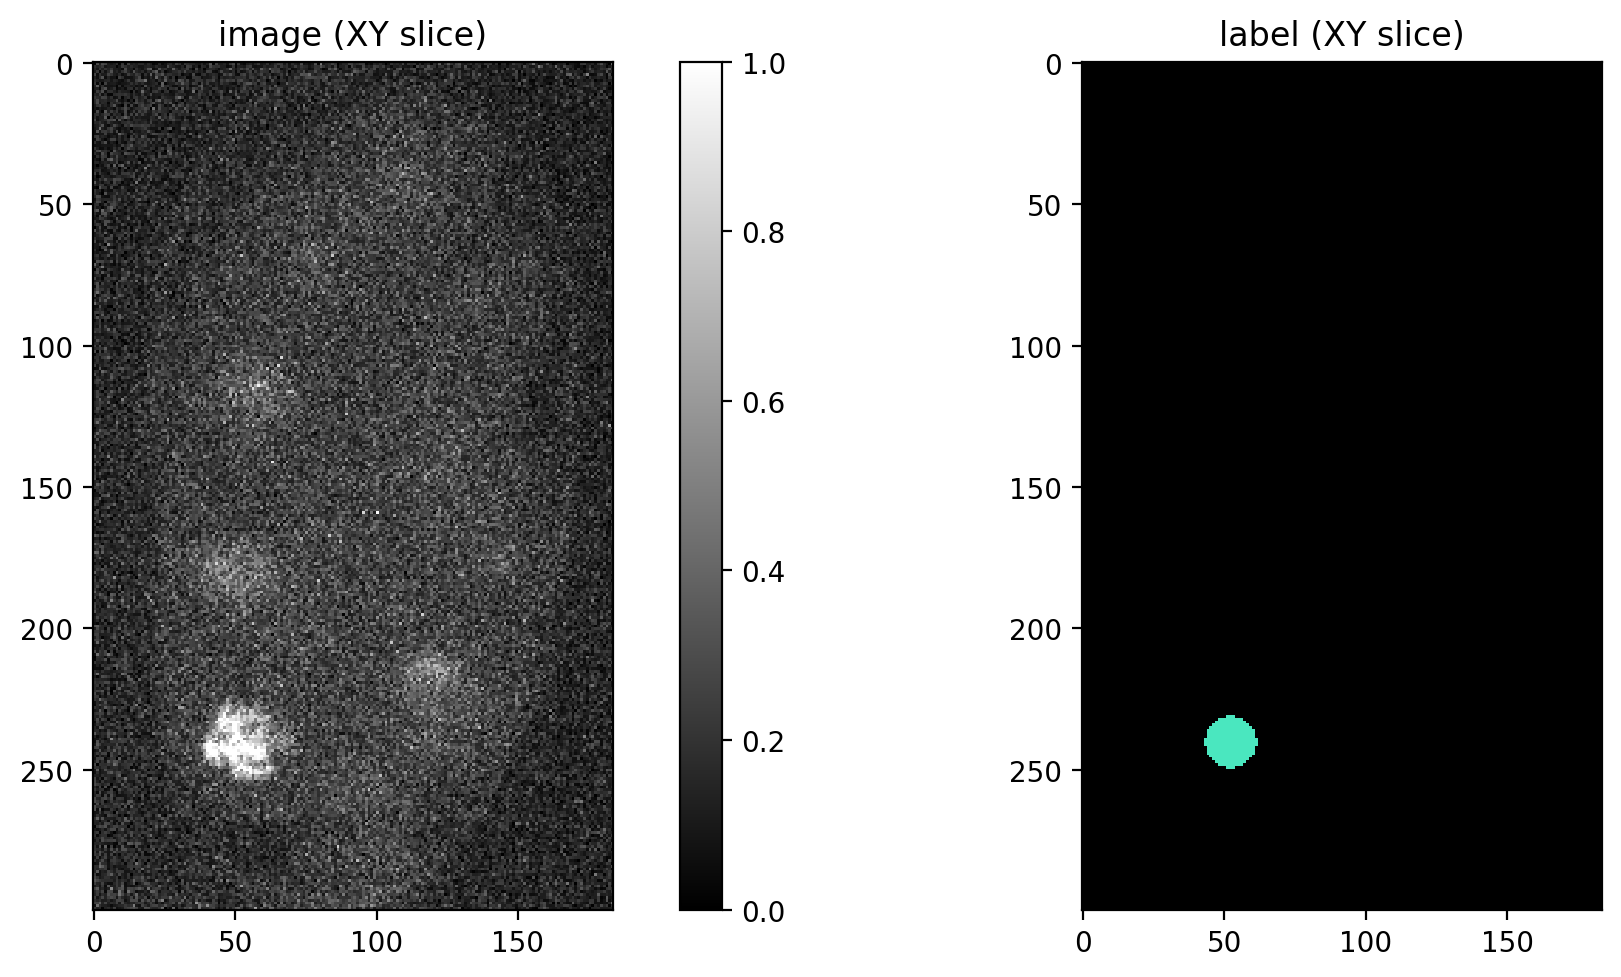

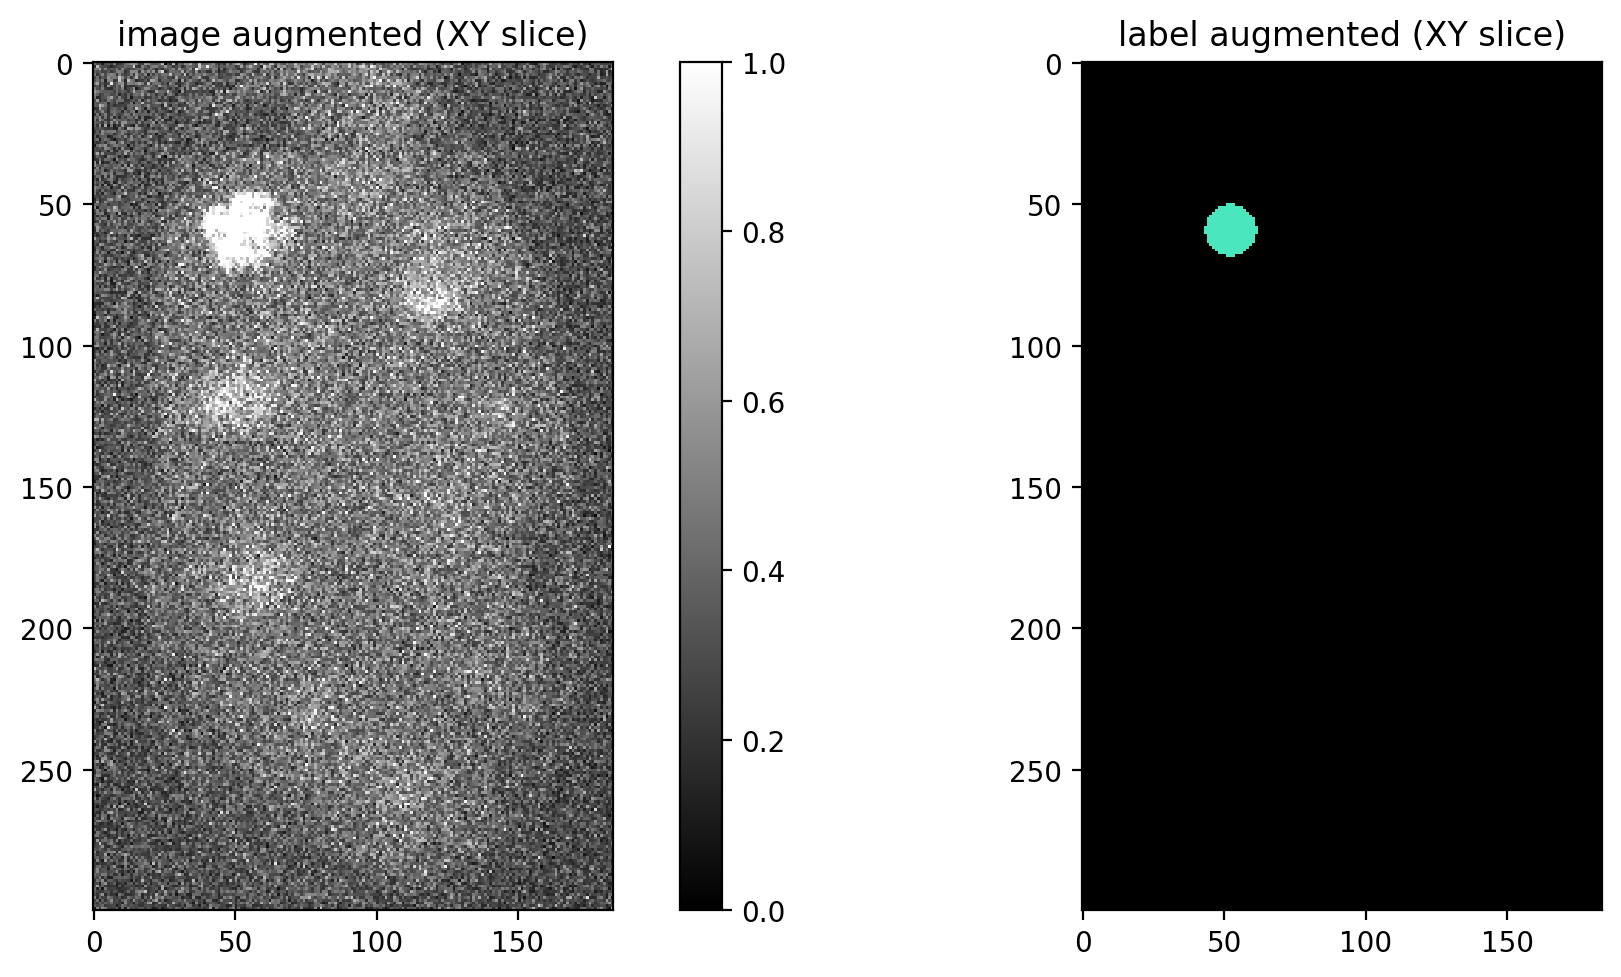

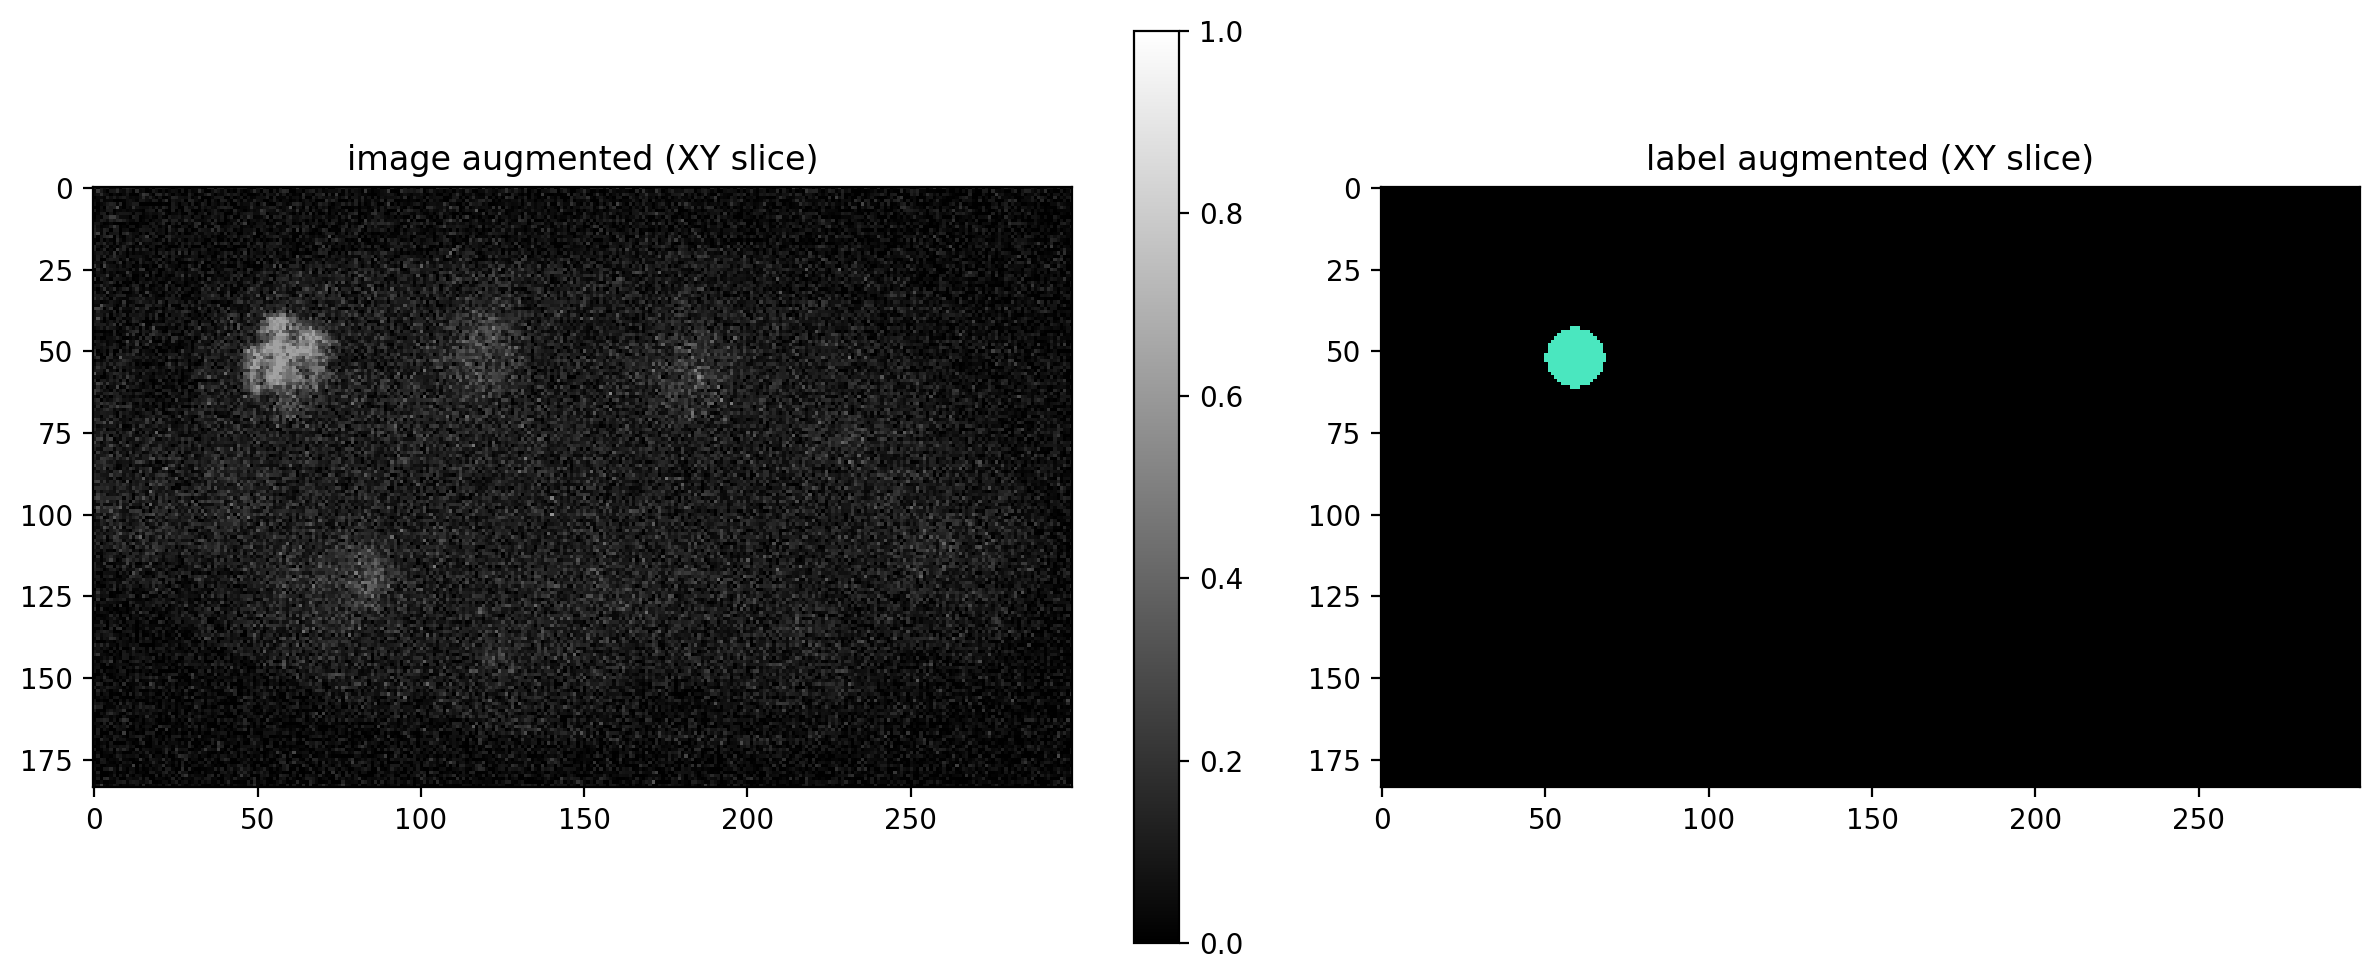

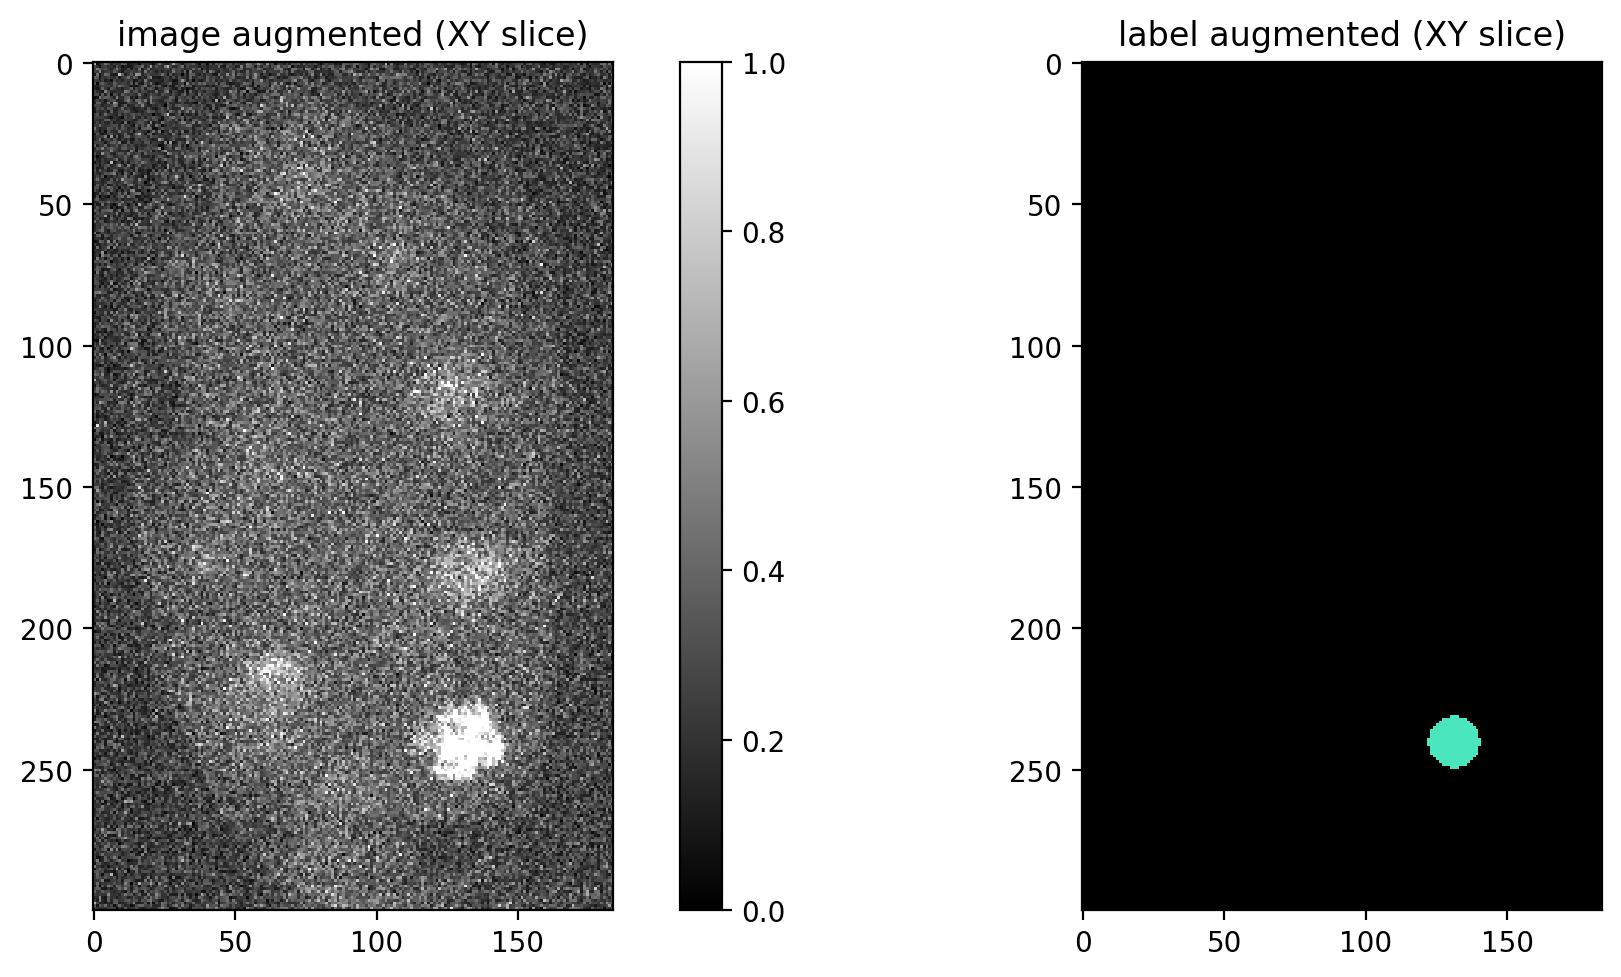

In [18]:
# plot some augmented examples
img, lbl = X[30],Y[30]
plot_img_label(img, lbl)
for _ in range(3):
    img_aug, lbl_aug = augmenter(img,lbl)
    plot_img_label(img_aug, lbl_aug, img_title="image augmented (XY slice)", lbl_title="label augmented (XY slice)")

# Training

We recommend to monitor the progress during training with [TensorBoard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard). You can start it in the shell from the current working directory like this:

    $ tensorboard --logdir=.

Then connect to [http://localhost:6006/](http://localhost:6006/) with your browser.


In [19]:
quick_demo = False

if quick_demo:
    print (
        "NOTE: This is only for a quick demonstration!\n"
        "      Please set the variable 'quick_demo = False' for proper (long) training.",
        file=sys.stderr, flush=True
    )
#     model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter,
#                 epochs=2, steps_per_epoch=5)

    print("====> Stopping training and loading previously trained demo model from disk.", file=sys.stderr, flush=True)
    model = StarDist3D.from_pretrained('3D_demo')
else:
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter, epochs=400)
None;

Epoch 1/400
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function _gcd_import at 0x7f9fd5c99430>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function _gcd_import at 0x7f9fd5c99430>. Note that functions defined in certain environments, like the interactive 

2024-08-15 15:18:39.246401: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 11188305920 exceeds 10% of free system memory.


100/100 [==============================] - 103s 991ms/step - loss: 1.4568 - prob_loss: 0.2629 - dist_loss: 5.9694 - prob_kld: 0.2059 - dist_relevant_mae: 5.9692 - dist_relevant_mse: 51.7088 - dist_dist_iou_metric: 0.1128 - val_loss: 0.8947 - val_prob_loss: 0.0926 - val_dist_loss: 4.0105 - val_prob_kld: 0.0650 - val_dist_relevant_mae: 4.0102 - val_dist_relevant_mse: 25.4255 - val_dist_dist_iou_metric: 0.2163
Epoch 2/400
100/100 [==============================] - 79s 791ms/step - loss: 0.8618 - prob_loss: 0.1219 - dist_loss: 3.6995 - prob_kld: 0.0919 - dist_relevant_mae: 3.6990 - dist_relevant_mse: 21.9305 - dist_dist_iou_metric: 0.3362 - val_loss: 0.6876 - val_prob_loss: 0.0694 - val_dist_loss: 3.0910 - val_prob_kld: 0.0418 - val_dist_relevant_mae: 3.0903 - val_dist_relevant_mse: 14.8900 - val_dist_dist_iou_metric: 0.3961
Epoch 3/400
100/100 [==============================] - 67s 676ms/step - loss: 0.7130 - prob_loss: 0.0802 - dist_loss: 3.1644 - prob_kld: 0.0534 - dist_relevant_mae: 3.

100/100 [==============================] - 68s 681ms/step - loss: 0.4101 - prob_loss: 0.0410 - dist_loss: 1.8457 - prob_kld: 0.0131 - dist_relevant_mae: 1.8451 - dist_relevant_mse: 6.1175 - dist_dist_iou_metric: 0.6457 - val_loss: 0.4184 - val_prob_loss: 0.0459 - val_dist_loss: 1.8624 - val_prob_kld: 0.0183 - val_dist_relevant_mae: 1.8619 - val_dist_relevant_mse: 5.6960 - val_dist_dist_iou_metric: 0.6096
Epoch 21/400
100/100 [==============================] - 75s 749ms/step - loss: 0.3869 - prob_loss: 0.0492 - dist_loss: 1.6882 - prob_kld: 0.0172 - dist_relevant_mae: 1.6876 - dist_relevant_mse: 4.8581 - dist_dist_iou_metric: 0.6604 - val_loss: 0.4170 - val_prob_loss: 0.0412 - val_dist_loss: 1.8790 - val_prob_kld: 0.0136 - val_dist_relevant_mae: 1.8785 - val_dist_relevant_mse: 5.7407 - val_dist_dist_iou_metric: 0.6127
Epoch 22/400
100/100 [==============================] - 76s 765ms/step - loss: 0.3780 - prob_loss: 0.0459 - dist_loss: 1.6602 - prob_kld: 0.0140 - dist_relevant_mae: 1.659

100/100 [==============================] - 69s 692ms/step - loss: 0.3288 - prob_loss: 0.0390 - dist_loss: 1.4490 - prob_kld: 0.0105 - dist_relevant_mae: 1.4485 - dist_relevant_mse: 3.5839 - dist_dist_iou_metric: 0.7087 - val_loss: 0.3297 - val_prob_loss: 0.0374 - val_dist_loss: 1.4616 - val_prob_kld: 0.0098 - val_dist_relevant_mae: 1.4610 - val_dist_relevant_mse: 3.6933 - val_dist_dist_iou_metric: 0.6955
Epoch 40/400
100/100 [==============================] - 63s 632ms/step - loss: 0.3391 - prob_loss: 0.0383 - dist_loss: 1.5038 - prob_kld: 0.0111 - dist_relevant_mae: 1.5032 - dist_relevant_mse: 3.7805 - dist_dist_iou_metric: 0.7024 - val_loss: 0.2982 - val_prob_loss: 0.0365 - val_dist_loss: 1.3082 - val_prob_kld: 0.0090 - val_dist_relevant_mae: 1.3076 - val_dist_relevant_mse: 3.0595 - val_dist_dist_iou_metric: 0.7403
Epoch 41/400
100/100 [==============================] - 75s 750ms/step - loss: 0.3396 - prob_loss: 0.0447 - dist_loss: 1.4745 - prob_kld: 0.0117 - dist_relevant_mae: 1.473

100/100 [==============================] - 65s 649ms/step - loss: 0.3123 - prob_loss: 0.0441 - dist_loss: 1.3408 - prob_kld: 0.0110 - dist_relevant_mae: 1.3402 - dist_relevant_mse: 3.1181 - dist_dist_iou_metric: 0.7220 - val_loss: 0.3101 - val_prob_loss: 0.0372 - val_dist_loss: 1.3645 - val_prob_kld: 0.0096 - val_dist_relevant_mae: 1.3639 - val_dist_relevant_mse: 3.2481 - val_dist_dist_iou_metric: 0.7262
Epoch 59/400
100/100 [==============================] - 74s 745ms/step - loss: 0.3169 - prob_loss: 0.0437 - dist_loss: 1.3661 - prob_kld: 0.0116 - dist_relevant_mae: 1.3656 - dist_relevant_mse: 3.2318 - dist_dist_iou_metric: 0.7202 - val_loss: 0.2930 - val_prob_loss: 0.0359 - val_dist_loss: 1.2855 - val_prob_kld: 0.0084 - val_dist_relevant_mae: 1.2849 - val_dist_relevant_mse: 2.8952 - val_dist_dist_iou_metric: 0.7346
Epoch 60/400
100/100 [==============================] - 66s 668ms/step - loss: 0.3153 - prob_loss: 0.0385 - dist_loss: 1.3845 - prob_kld: 0.0093 - dist_relevant_mae: 1.383

100/100 [==============================] - 65s 649ms/step - loss: 0.3032 - prob_loss: 0.0343 - dist_loss: 1.3442 - prob_kld: 0.0082 - dist_relevant_mae: 1.3437 - dist_relevant_mse: 3.0592 - dist_dist_iou_metric: 0.7354 - val_loss: 0.3105 - val_prob_loss: 0.0368 - val_dist_loss: 1.3686 - val_prob_kld: 0.0092 - val_dist_relevant_mae: 1.3681 - val_dist_relevant_mse: 3.2716 - val_dist_dist_iou_metric: 0.7395
Epoch 78/400
100/100 [==============================] - 69s 690ms/step - loss: 0.3024 - prob_loss: 0.0353 - dist_loss: 1.3357 - prob_kld: 0.0086 - dist_relevant_mae: 1.3352 - dist_relevant_mse: 3.1415 - dist_dist_iou_metric: 0.7365 - val_loss: 0.2880 - val_prob_loss: 0.0361 - val_dist_loss: 1.2595 - val_prob_kld: 0.0085 - val_dist_relevant_mae: 1.2591 - val_dist_relevant_mse: 2.8038 - val_dist_dist_iou_metric: 0.7447
Epoch 79/400
100/100 [==============================] - 72s 723ms/step - loss: 0.2969 - prob_loss: 0.0397 - dist_loss: 1.2859 - prob_kld: 0.0099 - dist_relevant_mae: 1.285

100/100 [==============================] - 81s 820ms/step - loss: 0.3045 - prob_loss: 0.0467 - dist_loss: 1.2890 - prob_kld: 0.0112 - dist_relevant_mae: 1.2886 - dist_relevant_mse: 2.8851 - dist_dist_iou_metric: 0.7331 - val_loss: 0.2996 - val_prob_loss: 0.0357 - val_dist_loss: 1.3194 - val_prob_kld: 0.0081 - val_dist_relevant_mae: 1.3188 - val_dist_relevant_mse: 3.0872 - val_dist_dist_iou_metric: 0.7502
Epoch 97/400
100/100 [==============================] - 59s 597ms/step - loss: 0.3050 - prob_loss: 0.0359 - dist_loss: 1.3459 - prob_kld: 0.0087 - dist_relevant_mae: 1.3454 - dist_relevant_mse: 3.1556 - dist_dist_iou_metric: 0.7319 - val_loss: 0.3209 - val_prob_loss: 0.0366 - val_dist_loss: 1.4211 - val_prob_kld: 0.0091 - val_dist_relevant_mae: 1.4205 - val_dist_relevant_mse: 3.4195 - val_dist_dist_iou_metric: 0.7274
Epoch 98/400
100/100 [==============================] - 71s 712ms/step - loss: 0.3253 - prob_loss: 0.0449 - dist_loss: 1.4017 - prob_kld: 0.0111 - dist_relevant_mae: 1.401

100/100 [==============================] - 74s 749ms/step - loss: 0.3062 - prob_loss: 0.0487 - dist_loss: 1.2877 - prob_kld: 0.0116 - dist_relevant_mae: 1.2872 - dist_relevant_mse: 2.8224 - dist_dist_iou_metric: 0.7355 - val_loss: 0.2893 - val_prob_loss: 0.0357 - val_dist_loss: 1.2678 - val_prob_kld: 0.0082 - val_dist_relevant_mae: 1.2674 - val_dist_relevant_mse: 2.8366 - val_dist_dist_iou_metric: 0.7505
Epoch 116/400
100/100 [==============================] - 63s 634ms/step - loss: 0.2939 - prob_loss: 0.0358 - dist_loss: 1.2907 - prob_kld: 0.0078 - dist_relevant_mae: 1.2902 - dist_relevant_mse: 2.9966 - dist_dist_iou_metric: 0.7440 - val_loss: 0.2991 - val_prob_loss: 0.0374 - val_dist_loss: 1.3086 - val_prob_kld: 0.0098 - val_dist_relevant_mae: 1.3082 - val_dist_relevant_mse: 3.0201 - val_dist_dist_iou_metric: 0.7415
Epoch 117/400
100/100 [==============================] - 67s 676ms/step - loss: 0.2965 - prob_loss: 0.0378 - dist_loss: 1.2937 - prob_kld: 0.0090 - dist_relevant_mae: 1.2

100/100 [==============================] - 67s 670ms/step - loss: 0.2847 - prob_loss: 0.0349 - dist_loss: 1.2495 - prob_kld: 0.0080 - dist_relevant_mae: 1.2490 - dist_relevant_mse: 2.7259 - dist_dist_iou_metric: 0.7489 - val_loss: 0.2806 - val_prob_loss: 0.0352 - val_dist_loss: 1.2271 - val_prob_kld: 0.0076 - val_dist_relevant_mae: 1.2266 - val_dist_relevant_mse: 2.6785 - val_dist_dist_iou_metric: 0.7597
Epoch 135/400
100/100 [==============================] - 75s 759ms/step - loss: 0.2977 - prob_loss: 0.0472 - dist_loss: 1.2529 - prob_kld: 0.0105 - dist_relevant_mae: 1.2525 - dist_relevant_mse: 2.7477 - dist_dist_iou_metric: 0.7414 - val_loss: 0.2738 - val_prob_loss: 0.0348 - val_dist_loss: 1.1948 - val_prob_kld: 0.0073 - val_dist_relevant_mae: 1.1943 - val_dist_relevant_mse: 2.6283 - val_dist_dist_iou_metric: 0.7712
Epoch 136/400
100/100 [==============================] - 60s 602ms/step - loss: 0.2680 - prob_loss: 0.0302 - dist_loss: 1.1888 - prob_kld: 0.0063 - dist_relevant_mae: 1.1

100/100 [==============================] - 74s 749ms/step - loss: 0.2727 - prob_loss: 0.0348 - dist_loss: 1.1895 - prob_kld: 0.0072 - dist_relevant_mae: 1.1891 - dist_relevant_mse: 2.4764 - dist_dist_iou_metric: 0.7657 - val_loss: 0.2752 - val_prob_loss: 0.0348 - val_dist_loss: 1.2019 - val_prob_kld: 0.0073 - val_dist_relevant_mae: 1.2014 - val_dist_relevant_mse: 2.5690 - val_dist_dist_iou_metric: 0.7485
Epoch 154/400
100/100 [==============================] - 78s 781ms/step - loss: 0.2836 - prob_loss: 0.0378 - dist_loss: 1.2286 - prob_kld: 0.0083 - dist_relevant_mae: 1.2281 - dist_relevant_mse: 2.6740 - dist_dist_iou_metric: 0.7512 - val_loss: 0.2883 - val_prob_loss: 0.0355 - val_dist_loss: 1.2642 - val_prob_kld: 0.0079 - val_dist_relevant_mae: 1.2638 - val_dist_relevant_mse: 2.7802 - val_dist_dist_iou_metric: 0.7419
Epoch 155/400
100/100 [==============================] - 72s 723ms/step - loss: 0.2786 - prob_loss: 0.0371 - dist_loss: 1.2074 - prob_kld: 0.0081 - dist_relevant_mae: 1.2

100/100 [==============================] - 69s 689ms/step - loss: 0.2852 - prob_loss: 0.0388 - dist_loss: 1.2323 - prob_kld: 0.0081 - dist_relevant_mae: 1.2319 - dist_relevant_mse: 2.7356 - dist_dist_iou_metric: 0.7537 - val_loss: 0.2607 - val_prob_loss: 0.0347 - val_dist_loss: 1.1299 - val_prob_kld: 0.0071 - val_dist_relevant_mae: 1.1295 - val_dist_relevant_mse: 2.3564 - val_dist_dist_iou_metric: 0.7732
Epoch 173/400
100/100 [==============================] - 66s 660ms/step - loss: 0.2819 - prob_loss: 0.0328 - dist_loss: 1.2451 - prob_kld: 0.0070 - dist_relevant_mae: 1.2447 - dist_relevant_mse: 2.7504 - dist_dist_iou_metric: 0.7515 - val_loss: 0.2856 - val_prob_loss: 0.0350 - val_dist_loss: 1.2532 - val_prob_kld: 0.0074 - val_dist_relevant_mae: 1.2527 - val_dist_relevant_mse: 2.8131 - val_dist_dist_iou_metric: 0.7599
Epoch 174/400
100/100 [==============================] - 76s 766ms/step - loss: 0.2820 - prob_loss: 0.0401 - dist_loss: 1.2096 - prob_kld: 0.0082 - dist_relevant_mae: 1.2

100/100 [==============================] - 65s 651ms/step - loss: 0.2610 - prob_loss: 0.0373 - dist_loss: 1.1183 - prob_kld: 0.0073 - dist_relevant_mae: 1.1179 - dist_relevant_mse: 2.1843 - dist_dist_iou_metric: 0.7727 - val_loss: 0.2663 - val_prob_loss: 0.0351 - val_dist_loss: 1.1563 - val_prob_kld: 0.0075 - val_dist_relevant_mae: 1.1559 - val_dist_relevant_mse: 2.4141 - val_dist_dist_iou_metric: 0.7668
Epoch 192/400
100/100 [==============================] - 73s 731ms/step - loss: 0.2797 - prob_loss: 0.0432 - dist_loss: 1.1825 - prob_kld: 0.0090 - dist_relevant_mae: 1.1820 - dist_relevant_mse: 2.5843 - dist_dist_iou_metric: 0.7579 - val_loss: 0.2809 - val_prob_loss: 0.0350 - val_dist_loss: 1.2291 - val_prob_kld: 0.0075 - val_dist_relevant_mae: 1.2287 - val_dist_relevant_mse: 2.6766 - val_dist_dist_iou_metric: 0.7478
Epoch 193/400
100/100 [==============================] - 75s 759ms/step - loss: 0.2780 - prob_loss: 0.0475 - dist_loss: 1.1521 - prob_kld: 0.0098 - dist_relevant_mae: 1.1

100/100 [==============================] - 80s 805ms/step - loss: 0.2859 - prob_loss: 0.0474 - dist_loss: 1.1922 - prob_kld: 0.0097 - dist_relevant_mae: 1.1918 - dist_relevant_mse: 2.5687 - dist_dist_iou_metric: 0.7494 - val_loss: 0.2794 - val_prob_loss: 0.0344 - val_dist_loss: 1.2251 - val_prob_kld: 0.0068 - val_dist_relevant_mae: 1.2246 - val_dist_relevant_mse: 2.7243 - val_dist_dist_iou_metric: 0.7671
Epoch 211/400
100/100 [==============================] - 63s 632ms/step - loss: 0.2636 - prob_loss: 0.0322 - dist_loss: 1.1571 - prob_kld: 0.0062 - dist_relevant_mae: 1.1567 - dist_relevant_mse: 2.3633 - dist_dist_iou_metric: 0.7699 - val_loss: 0.2539 - val_prob_loss: 0.0344 - val_dist_loss: 1.0978 - val_prob_kld: 0.0068 - val_dist_relevant_mae: 1.0974 - val_dist_relevant_mse: 2.2513 - val_dist_dist_iou_metric: 0.7760
Epoch 212/400
100/100 [==============================] - 64s 646ms/step - loss: 0.2704 - prob_loss: 0.0385 - dist_loss: 1.1596 - prob_kld: 0.0077 - dist_relevant_mae: 1.1

100/100 [==============================] - 69s 694ms/step - loss: 0.2613 - prob_loss: 0.0337 - dist_loss: 1.1381 - prob_kld: 0.0068 - dist_relevant_mae: 1.1377 - dist_relevant_mse: 2.3142 - dist_dist_iou_metric: 0.7699 - val_loss: 0.2687 - val_prob_loss: 0.0341 - val_dist_loss: 1.1731 - val_prob_kld: 0.0065 - val_dist_relevant_mae: 1.1727 - val_dist_relevant_mse: 2.4826 - val_dist_dist_iou_metric: 0.7581
Epoch 230/400
100/100 [==============================] - 75s 751ms/step - loss: 0.2654 - prob_loss: 0.0335 - dist_loss: 1.1596 - prob_kld: 0.0067 - dist_relevant_mae: 1.1592 - dist_relevant_mse: 2.3971 - dist_dist_iou_metric: 0.7663 - val_loss: 0.2599 - val_prob_loss: 0.0343 - val_dist_loss: 1.1281 - val_prob_kld: 0.0067 - val_dist_relevant_mae: 1.1277 - val_dist_relevant_mse: 2.3674 - val_dist_dist_iou_metric: 0.7775
Epoch 231/400
100/100 [==============================] - 58s 585ms/step - loss: 0.2596 - prob_loss: 0.0338 - dist_loss: 1.1288 - prob_kld: 0.0064 - dist_relevant_mae: 1.1

100/100 [==============================] - 70s 703ms/step - loss: 0.2726 - prob_loss: 0.0431 - dist_loss: 1.1471 - prob_kld: 0.0085 - dist_relevant_mae: 1.1467 - dist_relevant_mse: 2.4111 - dist_dist_iou_metric: 0.7665 - val_loss: 0.2734 - val_prob_loss: 0.0345 - val_dist_loss: 1.1947 - val_prob_kld: 0.0069 - val_dist_relevant_mae: 1.1943 - val_dist_relevant_mse: 2.5546 - val_dist_dist_iou_metric: 0.7592
Epoch 249/400
100/100 [==============================] - 65s 655ms/step - loss: 0.2681 - prob_loss: 0.0389 - dist_loss: 1.1460 - prob_kld: 0.0078 - dist_relevant_mae: 1.1456 - dist_relevant_mse: 2.4280 - dist_dist_iou_metric: 0.7676 - val_loss: 0.2522 - val_prob_loss: 0.0338 - val_dist_loss: 1.0922 - val_prob_kld: 0.0062 - val_dist_relevant_mae: 1.0917 - val_dist_relevant_mse: 2.2232 - val_dist_dist_iou_metric: 0.7763
Epoch 250/400
100/100 [==============================] - 64s 648ms/step - loss: 0.2634 - prob_loss: 0.0383 - dist_loss: 1.1259 - prob_kld: 0.0076 - dist_relevant_mae: 1.1

100/100 [==============================] - 67s 677ms/step - loss: 0.2616 - prob_loss: 0.0342 - dist_loss: 1.1373 - prob_kld: 0.0067 - dist_relevant_mae: 1.1369 - dist_relevant_mse: 2.3435 - dist_dist_iou_metric: 0.7703 - val_loss: 0.2482 - val_prob_loss: 0.0337 - val_dist_loss: 1.0727 - val_prob_kld: 0.0061 - val_dist_relevant_mae: 1.0722 - val_dist_relevant_mse: 2.1864 - val_dist_dist_iou_metric: 0.7862
Epoch 268/400
100/100 [==============================] - 81s 819ms/step - loss: 0.2672 - prob_loss: 0.0404 - dist_loss: 1.1343 - prob_kld: 0.0080 - dist_relevant_mae: 1.1338 - dist_relevant_mse: 2.3245 - dist_dist_iou_metric: 0.7697 - val_loss: 0.2472 - val_prob_loss: 0.0343 - val_dist_loss: 1.0649 - val_prob_kld: 0.0067 - val_dist_relevant_mae: 1.0644 - val_dist_relevant_mse: 2.1457 - val_dist_dist_iou_metric: 0.7850
Epoch 269/400
100/100 [==============================] - 78s 788ms/step - loss: 0.2651 - prob_loss: 0.0411 - dist_loss: 1.1199 - prob_kld: 0.0078 - dist_relevant_mae: 1.1

100/100 [==============================] - 71s 712ms/step - loss: 0.2665 - prob_loss: 0.0396 - dist_loss: 1.1349 - prob_kld: 0.0077 - dist_relevant_mae: 1.1344 - dist_relevant_mse: 2.3464 - dist_dist_iou_metric: 0.7705 - val_loss: 0.2373 - val_prob_loss: 0.0337 - val_dist_loss: 1.0179 - val_prob_kld: 0.0061 - val_dist_relevant_mae: 1.0174 - val_dist_relevant_mse: 2.0163 - val_dist_dist_iou_metric: 0.7950
Epoch 287/400
100/100 [==============================] - 66s 664ms/step - loss: 0.2668 - prob_loss: 0.0343 - dist_loss: 1.1622 - prob_kld: 0.0070 - dist_relevant_mae: 1.1618 - dist_relevant_mse: 2.5088 - dist_dist_iou_metric: 0.7688 - val_loss: 0.2940 - val_prob_loss: 0.0353 - val_dist_loss: 1.2934 - val_prob_kld: 0.0078 - val_dist_relevant_mae: 1.2930 - val_dist_relevant_mse: 2.9018 - val_dist_dist_iou_metric: 0.7404
Epoch 288/400
100/100 [==============================] - 66s 668ms/step - loss: 0.2632 - prob_loss: 0.0395 - dist_loss: 1.1184 - prob_kld: 0.0077 - dist_relevant_mae: 1.1

100/100 [==============================] - 62s 628ms/step - loss: 0.2500 - prob_loss: 0.0372 - dist_loss: 1.0643 - prob_kld: 0.0068 - dist_relevant_mae: 1.0639 - dist_relevant_mse: 2.1095 - dist_dist_iou_metric: 0.7833 - val_loss: 0.2570 - val_prob_loss: 0.0339 - val_dist_loss: 1.1152 - val_prob_kld: 0.0064 - val_dist_relevant_mae: 1.1148 - val_dist_relevant_mse: 2.3029 - val_dist_dist_iou_metric: 0.7797
Epoch 306/400
100/100 [==============================] - 78s 782ms/step - loss: 0.2555 - prob_loss: 0.0434 - dist_loss: 1.0609 - prob_kld: 0.0081 - dist_relevant_mae: 1.0605 - dist_relevant_mse: 2.1002 - dist_dist_iou_metric: 0.7817 - val_loss: 0.2625 - val_prob_loss: 0.0341 - val_dist_loss: 1.1423 - val_prob_kld: 0.0065 - val_dist_relevant_mae: 1.1420 - val_dist_relevant_mse: 2.4005 - val_dist_dist_iou_metric: 0.7690
Epoch 307/400
100/100 [==============================] - 77s 771ms/step - loss: 0.2639 - prob_loss: 0.0414 - dist_loss: 1.1127 - prob_kld: 0.0080 - dist_relevant_mae: 1.1

100/100 [==============================] - 64s 642ms/step - loss: 0.2506 - prob_loss: 0.0395 - dist_loss: 1.0555 - prob_kld: 0.0074 - dist_relevant_mae: 1.0551 - dist_relevant_mse: 2.0235 - dist_dist_iou_metric: 0.7814 - val_loss: 0.2514 - val_prob_loss: 0.0343 - val_dist_loss: 1.0853 - val_prob_kld: 0.0067 - val_dist_relevant_mae: 1.0850 - val_dist_relevant_mse: 2.1839 - val_dist_dist_iou_metric: 0.7768
Epoch 325/400
100/100 [==============================] - 56s 558ms/step - loss: 0.2474 - prob_loss: 0.0302 - dist_loss: 1.0860 - prob_kld: 0.0056 - dist_relevant_mae: 1.0856 - dist_relevant_mse: 2.1927 - dist_dist_iou_metric: 0.7832 - val_loss: 0.2528 - val_prob_loss: 0.0340 - val_dist_loss: 1.0943 - val_prob_kld: 0.0064 - val_dist_relevant_mae: 1.0939 - val_dist_relevant_mse: 2.2306 - val_dist_dist_iou_metric: 0.7818
Epoch 326/400
100/100 [==============================] - 74s 745ms/step - loss: 0.2588 - prob_loss: 0.0412 - dist_loss: 1.0877 - prob_kld: 0.0080 - dist_relevant_mae: 1.0

100/100 [==============================] - 72s 728ms/step - loss: 0.2499 - prob_loss: 0.0387 - dist_loss: 1.0563 - prob_kld: 0.0072 - dist_relevant_mae: 1.0559 - dist_relevant_mse: 2.0941 - dist_dist_iou_metric: 0.7844 - val_loss: 0.2470 - val_prob_loss: 0.0340 - val_dist_loss: 1.0653 - val_prob_kld: 0.0064 - val_dist_relevant_mae: 1.0650 - val_dist_relevant_mse: 2.1498 - val_dist_dist_iou_metric: 0.7828
Epoch 344/400
100/100 [==============================] - 77s 775ms/step - loss: 0.2542 - prob_loss: 0.0437 - dist_loss: 1.0527 - prob_kld: 0.0078 - dist_relevant_mae: 1.0524 - dist_relevant_mse: 2.0776 - dist_dist_iou_metric: 0.7814 - val_loss: 0.2601 - val_prob_loss: 0.0343 - val_dist_loss: 1.1288 - val_prob_kld: 0.0067 - val_dist_relevant_mae: 1.1284 - val_dist_relevant_mse: 2.3325 - val_dist_dist_iou_metric: 0.7747
Epoch 345/400
100/100 [==============================] - 62s 621ms/step - loss: 0.2600 - prob_loss: 0.0309 - dist_loss: 1.1455 - prob_kld: 0.0060 - dist_relevant_mae: 1.1

100/100 [==============================] - 67s 678ms/step - loss: 0.2451 - prob_loss: 0.0345 - dist_loss: 1.0531 - prob_kld: 0.0066 - dist_relevant_mae: 1.0528 - dist_relevant_mse: 2.1080 - dist_dist_iou_metric: 0.7831 - val_loss: 0.2310 - val_prob_loss: 0.0333 - val_dist_loss: 0.9885 - val_prob_kld: 0.0057 - val_dist_relevant_mae: 0.9881 - val_dist_relevant_mse: 1.9371 - val_dist_dist_iou_metric: 0.8007
Epoch 363/400
100/100 [==============================] - 69s 693ms/step - loss: 0.2442 - prob_loss: 0.0298 - dist_loss: 1.0717 - prob_kld: 0.0057 - dist_relevant_mae: 1.0713 - dist_relevant_mse: 2.1165 - dist_dist_iou_metric: 0.7867 - val_loss: 0.2477 - val_prob_loss: 0.0340 - val_dist_loss: 1.0684 - val_prob_kld: 0.0064 - val_dist_relevant_mae: 1.0681 - val_dist_relevant_mse: 2.1575 - val_dist_dist_iou_metric: 0.7822
Epoch 364/400
100/100 [==============================] - 67s 673ms/step - loss: 0.2483 - prob_loss: 0.0414 - dist_loss: 1.0346 - prob_kld: 0.0075 - dist_relevant_mae: 1.0

100/100 [==============================] - 72s 727ms/step - loss: 0.2468 - prob_loss: 0.0377 - dist_loss: 1.0455 - prob_kld: 0.0068 - dist_relevant_mae: 1.0451 - dist_relevant_mse: 2.0514 - dist_dist_iou_metric: 0.7856 - val_loss: 0.2635 - val_prob_loss: 0.0338 - val_dist_loss: 1.1484 - val_prob_kld: 0.0063 - val_dist_relevant_mae: 1.1481 - val_dist_relevant_mse: 2.3878 - val_dist_dist_iou_metric: 0.7610
Epoch 382/400
100/100 [==============================] - 64s 647ms/step - loss: 0.2551 - prob_loss: 0.0403 - dist_loss: 1.0741 - prob_kld: 0.0074 - dist_relevant_mae: 1.0737 - dist_relevant_mse: 2.1035 - dist_dist_iou_metric: 0.7769 - val_loss: 0.2582 - val_prob_loss: 0.0341 - val_dist_loss: 1.1209 - val_prob_kld: 0.0065 - val_dist_relevant_mae: 1.1205 - val_dist_relevant_mse: 2.3264 - val_dist_dist_iou_metric: 0.7755
Epoch 383/400
100/100 [==============================] - 61s 612ms/step - loss: 0.2509 - prob_loss: 0.0305 - dist_loss: 1.1020 - prob_kld: 0.0056 - dist_relevant_mae: 1.1

100/100 [==============================] - 63s 630ms/step - loss: 0.2447 - prob_loss: 0.0343 - dist_loss: 1.0522 - prob_kld: 0.0063 - dist_relevant_mae: 1.0519 - dist_relevant_mse: 2.0842 - dist_dist_iou_metric: 0.7911 - val_loss: 0.2410 - val_prob_loss: 0.0341 - val_dist_loss: 1.0345 - val_prob_kld: 0.0065 - val_dist_relevant_mae: 1.0342 - val_dist_relevant_mse: 2.0392 - val_dist_dist_iou_metric: 0.7903

Loading network weights from 'weights_best.h5'.


# Threshold optimization

While the default values for the probability and non-maximum suppression thresholds already yield good results in many cases, we still recommend to adapt the thresholds to your data. The optimized threshold values are saved to disk and will be automatically loaded with the model.

In [20]:
model = StarDist3D(None, name='stardist_nuc', basedir='models')
quick_demo = False

if quick_demo:
    # only use a single validation image for demo
    model.optimize_thresholds(X_val[:1], Y_val[:1])
else:
    model.optimize_thresholds(X_val[:50], Y_val[:50])

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.7968, nms_thresh=0.3.


NMS threshold = 0.5:  75%|███████████████████████████         | 15/20 [11:53<03:57, 47.54s/it, 0.679 -> 0.343]


Using optimized values: prob_thresh=0.677215, nms_thresh=0.3.
Saving to 'thresholds.json'.


In [21]:
model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  75%|██████████████████████████▎        | 15/20 [26:22<08:47, 105.53s/it, 0.675 -> 0.368]


Using optimized values: prob_thresh=0.67473, nms_thresh=0.3.
Saving to 'thresholds.json'.


{'prob': 0.6747304631916575, 'nms': 0.3}

# Evaluation and Detection Performance

Besides the losses and metrics during training, we can also quantitatively evaluate the actual detection/segmentation performance on the validation data by considering objects in the ground truth to be correctly matched if there are predicted objects with overlap (here [intersection over union (IoU)](https://en.wikipedia.org/wiki/Jaccard_index)) beyond a chosen IoU threshold $\tau$.

The corresponding matching statistics (average overlap, accuracy, recall, precision, etc.) are typically of greater practical relevance than the losses/metrics computed during training (but harder to formulate as a loss function). 
The value of $\tau$ can be between 0 (even slightly overlapping objects count as correctly predicted) and 1 (only pixel-perfectly overlapping objects count) and which $\tau$ to use depends on the needed segmentation precision/application.

Please see `help(matching)` for definitions of the abbreviations used in the evaluation below and see the Wikipedia page on [Sensitivity and specificity](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) for further details.

In [ ]:
# help(matching)

First predict the labels for all validation images:

In [22]:
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]

100%|███████████████████████████████████████████████████████████████████████| 110/110 [05:52<00:00,  3.21s/it]


Plot a GT/prediction example  

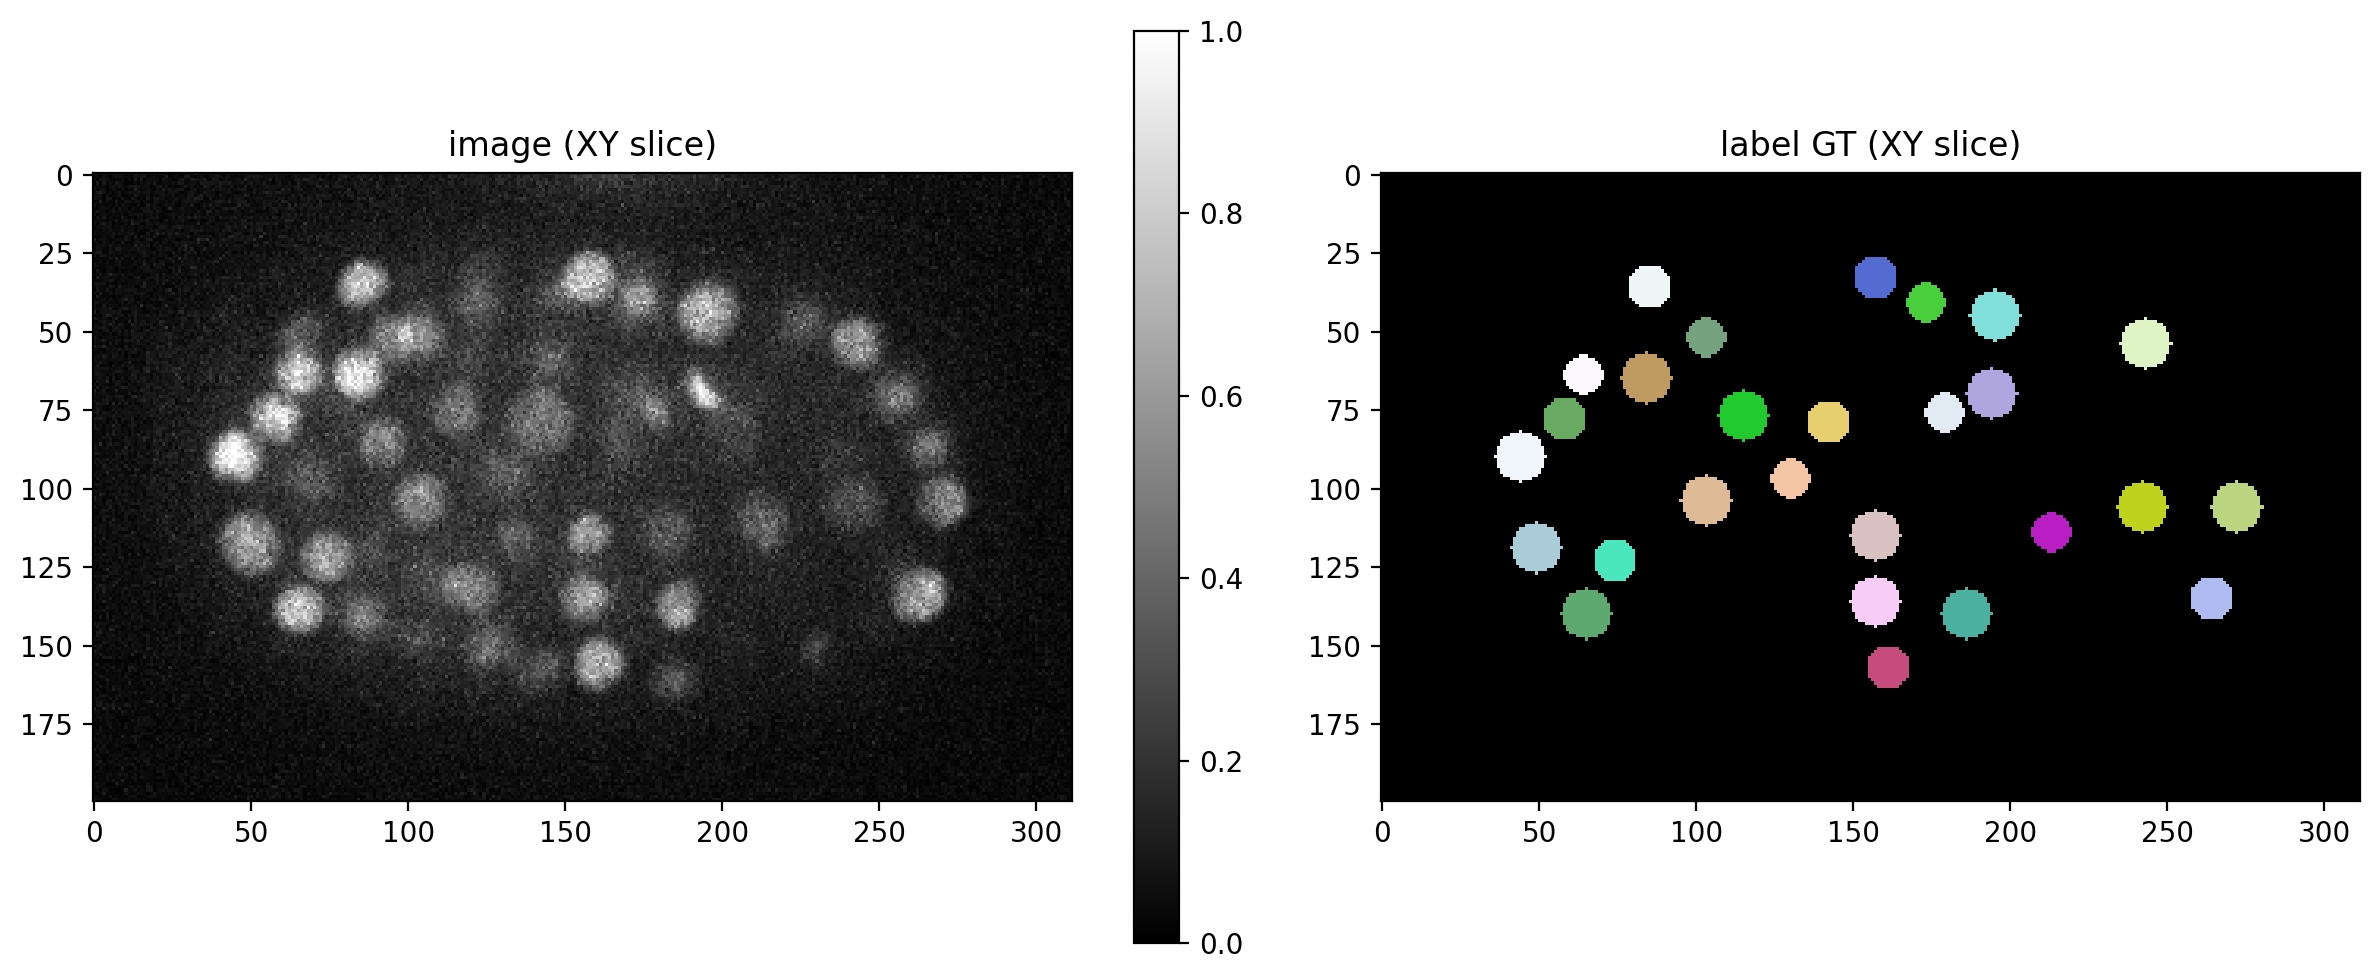

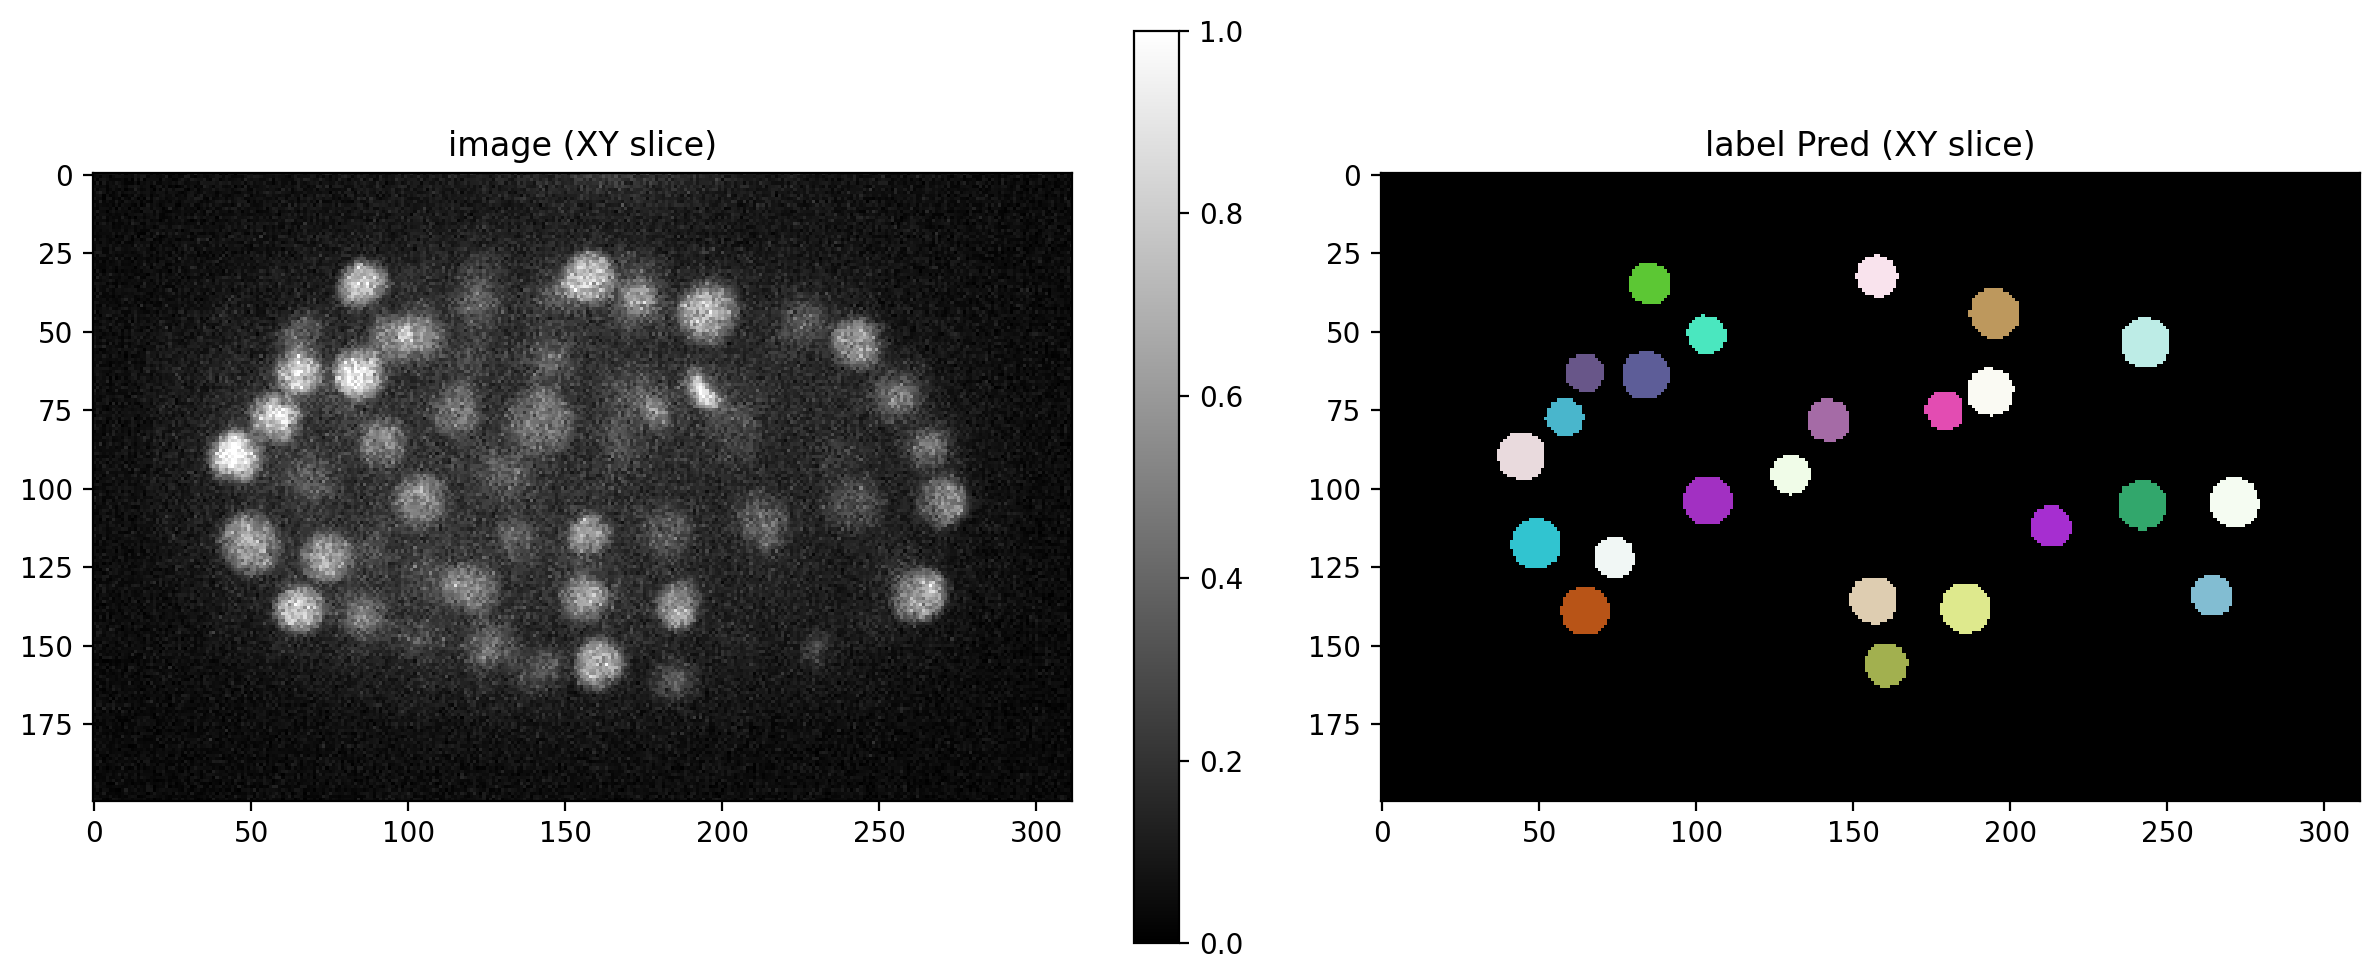

In [27]:
which_one=100
plot_img_label(X_val[which_one],Y_val[which_one], lbl_title="label GT (XY slice)")
plot_img_label(X_val[which_one],Y_val_pred[which_one], lbl_title="label Pred (XY slice)")

Choose several IoU thresholds $\tau$ that might be of interest and for each compute matching statistics for the validation data.

In [28]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]


100%|███████████████████████████████████████████████████████████████████████████| 9/9 [05:50<00:00, 38.97s/it]


Example: Print all available matching statistics for $\tau=0.7$

In [29]:
stats[taus.index(0.7)]

DatasetMatching(criterion='iou', thresh=0.7, fp=7240, tp=3881, fn=5098, precision=0.34897940832658936, recall=0.43223076066377103, accuracy=0.2392872556877736, f1=0.3861691542288557, n_true=8979, n_pred=11121, mean_true_score=0.3455659315572548, mean_matched_score=0.7994940735512989, panoptic_quality=0.3087399501942877, by_image=False)

Plot the matching statistics and the number of true/false positives/negatives as a function of the IoU threshold $\tau$. 

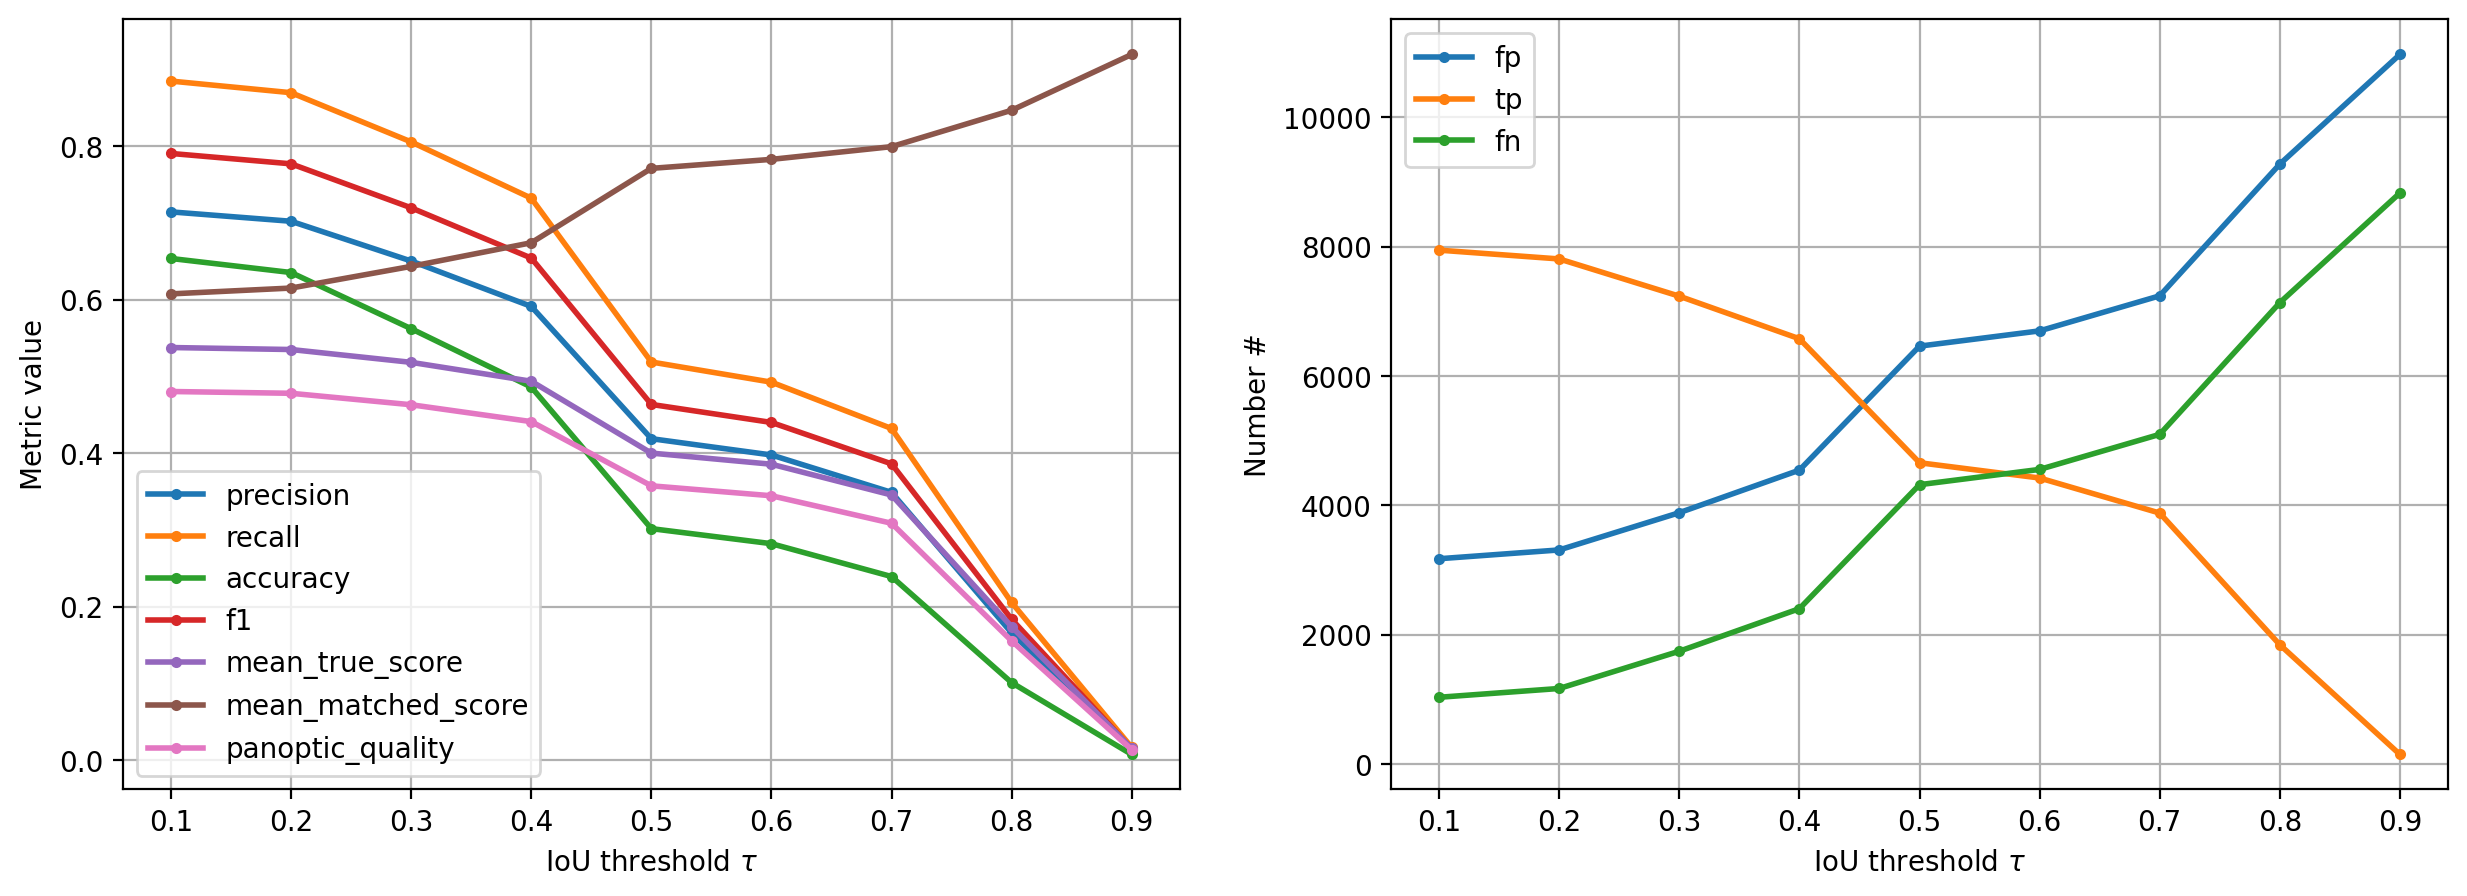

In [30]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();